## Home Loan Application Analysis using Aequitas
<a id='top_cell'></a>
Recent work in the Machine Learning community has raised concerns about the risk of unintended bias in Algorithmic Decision-Making systems, affecting individuals unfairly. While many bias metrics and fairness definitions have been proposed in recent years, the community has not reached a consensus on which definitions and metrics should be used, and there has been very little empirical analyses of real-world problems using the proposed metrics.

We present the Aequitas toolkit as an intuitive addition to the machine learning workflow, enabling users to to seamlessly test models for several bias and fairness metrics in relation to multiple population groups. We believe the tool will faciliate informed and equitable decision-making around developing and deploying predictive risk-assessment tools for both machine learnining practitioners and policymakers, allowing researchers and program managers to answer a host of questions related to machine learning models, including:

- [What biases exist in my model?](#existing_biases)
    - [What is the distribution of groups, predicted scores, and labels across my dataset?](#xtab)
    - [What are bias metrics across groups?](#xtab_metrics)
    - [How do I interpret biases in my model?](#interpret_bias)
    - [How do I visualize biases in my model?](#bias_viz)

- [What levels of disparity exist between population groups?](#disparities)
    - [How does the selected reference group affect disparity calculations?](#disparity_calc)
    - [How do I interpret calculated disparity ratios?](#interpret_disp)
    - [How do I visualize disparities in my model?](#disparity_viz)

- [How do I assess model fairness??](#fairness)
    - [How do I interpret parities?](#interpret_fairness)
    - [How do I visualize bias metric parity?](#fairness_group_viz)
    - [How do I visualize parity between groups in my model?](#fairness_disp_viz)


We apply the toolkit to the COMPAS dataset reported on by ProPublica below.

### Background

The dataset contains information on 614 loan applications, with 13 features including gender, marital status, income, loan amount, credit history, and loan status (https://www.kaggle.com/datasets/altruistdelhite04/loan-prediction-problem-dataset). The goal is to build a predictive model to determine the likelihood of loan approval.

#### Problem Statement
Dreamhouse Loan Company specializes in providing various types of loans across urban, semi-urban, and rural areas. When a loan application is received, the company validates the applicant’s eligibility based on details such as age, house ownership, work experience, loan intent, income, loan amount, and credit history (https://www.kaggle.com/datasets/altruistdelhite04/loan-prediction-problem-dataset). The objective is to streamline and automate this process to identify eligible customer segments and optimize loan offerings (https://www.kaggle.com/datasets/altruistdelhite04/loan-prediction-problem-dataset).

#### History
The dataset is part of a broader effort to improve the loan approval process by leveraging data analytics and machine learning. It has been used in various predictive modeling projects to enhance the accuracy and efficiency of loan eligibility assessments (https://www.kaggle.com/datasets/altruistdelhite04/loan-prediction-problem-dataset).

In [1]:
!pip install "aequitas==1.0.0" &> /dev/null

import pandas as pd
import seaborn as sns
from aequitas.audit import Audit
from aequitas.fairness import Fairness
import aequitas.plot as ap
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

# supress deprecation warnings from TF
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print(f"tensorflow: {tf.__version__}")

from IPython.display import Markdown, display
# import warnings; warnings.simplefilter('ignore')

%matplotlib inline

tensorflow: 2.4.1


/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/torch/_functorch/deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


In [2]:
from helpers.mlp_prediction import *

datasetX, dataset ,target, numerical, categorical = load_and_preprocess_data('/Users/nilsness/Desktop/Uni Skripte und Folien/Masterarbeit/Programming/Loan-Approval-Prediction.csv')

x_train_encoded, x_test_encoded, y_train, y_test, Z_train, Z_test, datasetX1, target,Z, dataset_num_headers, scaler, encoder = do_it_like_numbers_do(datasetX,target,numerical, categorical)


In [3]:
dataset_num_headers

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
1,1,1,1,0,0,0.054830,0.044567,0.201354,0.729730,1,0
2,1,1,0,0,1,0.035250,0.000000,0.096447,0.729730,1,0
3,1,1,0,1,0,0.030093,0.069687,0.187817,0.729730,1,0
4,1,0,0,0,0,0.072356,0.000000,0.223350,0.729730,1,0
5,1,1,2,0,1,0.065145,0.124006,0.436548,0.729730,1,0
...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,0,0,0,0.034014,0.000000,0.104907,0.729730,1,0
610,1,1,3,0,0,0.048930,0.000000,0.052453,0.324324,1,0
611,1,1,1,0,0,0.097984,0.007093,0.412860,0.729730,1,0
612,1,1,2,0,0,0.091936,0.000000,0.301184,0.729730,1,0


In [4]:
predictions = pd.read_csv('unfair_adv_predictions.csv')
predictions
predictions.drop(columns=['Unnamed: 0'])



,0
0,0.845466
1,0.881151
2,0.785563
3,0.766109
4,0.800133
...,...
475,0.826667
476,0.906166
477,0.826621
478,0.855738


In [5]:
prediction_rounded = np.where(predictions['0'] > 0.5, int(1), int(0))
prediction_rounded

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [6]:
dataset['Predictions']=prediction_rounded

Accuracy: 0.8208333333333333
Precision: 0.8044554455445545
Recall: 0.9789156626506024
F1-Score: 0.8831521739130435


/var/folders/xc/73h9x30561961rsyzf84xbvm0000gn/T/ipykernel_24216/1809065744.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test = dataset['Loan_Status'].replace({'Y': 1, 'N': 0})


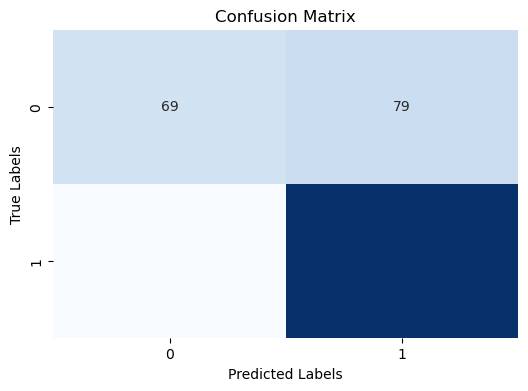

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_test = dataset['Loan_Status'].replace({'Y': 1, 'N': 0})
y_pred = dataset['Predictions']

# Berechnung der Genauigkeit
accuracy = accuracy_score(y_test, y_pred)

# Berechnung der Präzision
precision = precision_score(y_test, y_pred)

# Berechnung des Recall
recall = recall_score(y_test, y_pred)

# Berechnung des F1-Scores
f1 = f1_score(y_test, y_pred)
# Berechnung der Ks =_(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)



import matplotlib.pyplot as plt


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [8]:
dataset['Predictions'].replace({0:'N',1:'Y'}, inplace=True)

[Back to Top](#top_cell)
<a id='xtab_metrics'></a>

### What are bias metrics across groups?

Once you have run the `Group()` class **`get_crosstabs()`** method, you'll have a dataframe of the [group counts](#counts_description) and [group value bias metrics](#counts_description).

The `Group()` class has a **`list_absolute_metrics()`** method, which you can use for faster slicing to view just  counts or bias metrics.

In [9]:
aq_palette = sns.diverging_palette(225, 35, n=2)

In [10]:
df=dataset
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Predictions
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,Y
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,Y
5,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y,Y


In [11]:
df.Property_Area.unique()

array(['Rural', 'Urban', 'Semiurban'], dtype=object)

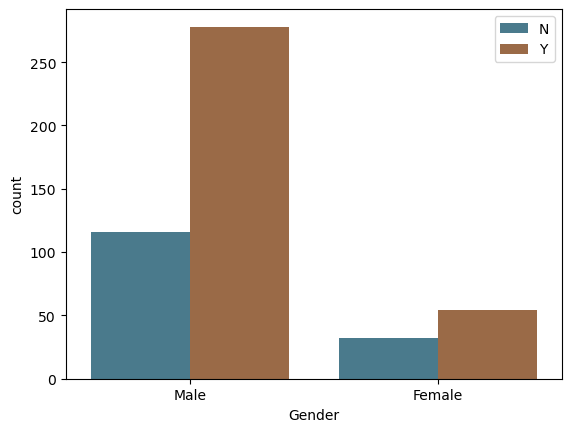

In [12]:
gender_plot = sns.countplot(x="Gender", hue="Loan_Status", data=df[df.Gender.isin(['Male', 'Female'])], palette=aq_palette)
plt.legend(loc='upper right')

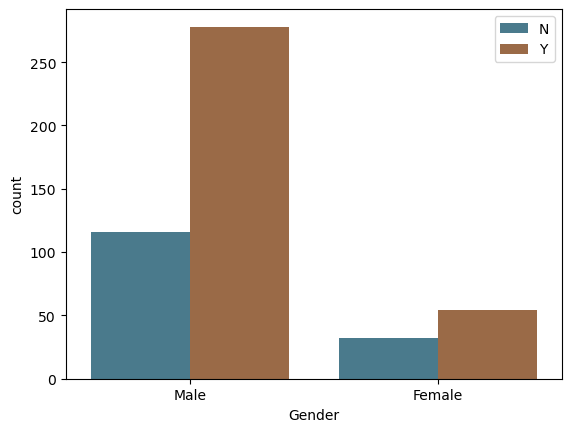

In [13]:


by_gender = sns.countplot(x="Gender", hue="Loan_Status", data=df[df.Gender.isin(['Male', 'Female'])], palette=aq_palette)
plt.legend(loc='upper right')


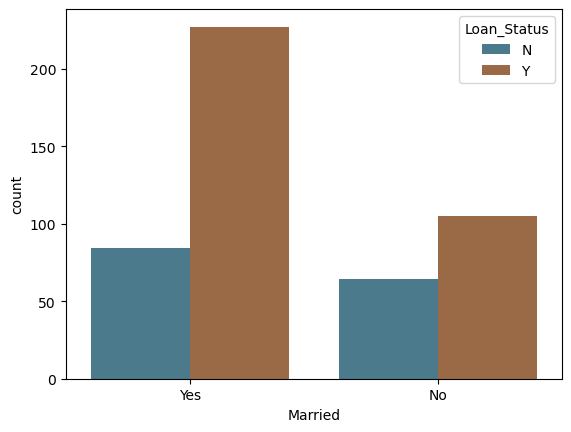

In [14]:
by_marriage = sns.countplot(x="Married", hue="Loan_Status", data=df, palette=aq_palette)

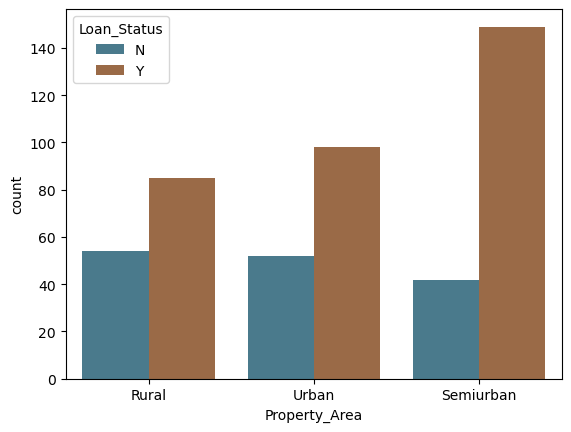

In [15]:
by_property = sns.countplot(x="Property_Area", hue="Loan_Status", data=df, palette=aq_palette)

# Aequitas Visualizations

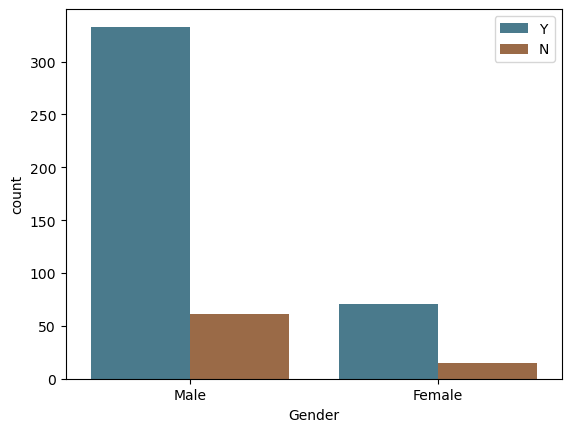

In [16]:
gender_plot = sns.countplot(x="Gender", hue="Predictions", data=df[df.Gender.isin(['Male', 'Female'])], palette=aq_palette)
plt.legend(loc='upper right')

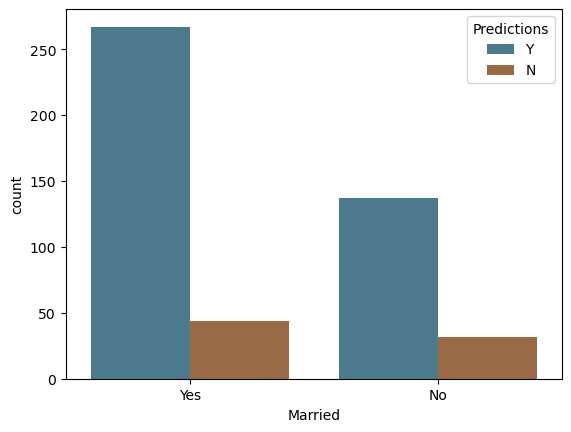

In [17]:
label_by_marital = sns.countplot(x="Married", hue="Predictions", data=df, palette=aq_palette)

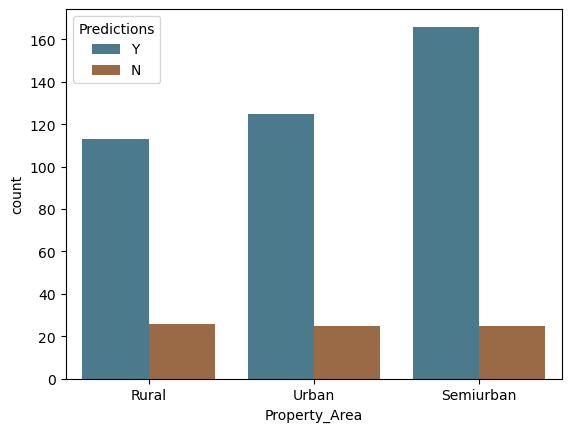

In [18]:
label_by_sex = sns.countplot(x="Property_Area", hue="Predictions", data=df, palette=aq_palette)

#### Check how the fairness threshold maps to the absolute values of each metric


### Check for disparities in Education, Self_Employed and Dependents

#### Check how the fairness threshold maps to the absolute values of each metric


[Back to Top](#top_cell)
<a id='interpret_disp'></a>

### How do I interpret calculated disparity ratios?
The calculated disparities from the dataframe returned by the `Bias()` class **`get_disparity_`** methods are in relation to a reference group, which will always have a disparity of 1.0.

The differences in False Positive Rates, noted in the discussion of the `Group()` class above, are clarified using the disparity ratio (`fpr_disparity`). Females are falsely identified as being high or medium risks 1.07 times the rate for Males.

As seen above, False Discovery Rates have a higher disparity (`fdr_disparity`), or fraction of false postives over predicted positive in a group. As reference groups have disparity = 1 by design in Aequitas, the lower disparity is highlighted by the `fdr_disparity` value close to 1.71 for the gender attribute group 'Female' when disparities are calculated using predefined base group 'Male'.

[Back to Top](#top_cell)
<a id='disparity_calc'></a>

### How does the selected reference group affect disparity calculations?

Disparities calculated in the the Aequitas `Bias()` class based on the crosstab returned by the `Group()` class **`get_crosstabs()`** method can be derived using several different base gorups. In addition to using user-specified groups illustrated above, Aequitas can automate base group selection based on dataset characterisitcs:

#### Disparities calculated in relation to sample population majority group (in terms of group prevalence) for each attribute
The majority population groups for each attribute ('gender', 'property are', 'self employed') in the COMPAS dataset are 'Male', 'Urban', and 'No'. Using the **`get_disparity_major_group()`** method of calculation allows researchers to quickly evaluate how much more (or less often) other groups are falsely or correctly identified as high- or medium-risk in relation to the group they have the most data on.

In [19]:
df.rename(columns={'Loan_Status': 'label_value'}, inplace=True)
df.rename(columns={'Predictions': 'score'}, inplace=True)
df['label_value'].replace({'N':0,'Y':1},inplace=True)
df['score'].replace({'N':0,'Y':1},inplace=True)
df

/var/folders/xc/73h9x30561961rsyzf84xbvm0000gn/T/ipykernel_24216/3026626232.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['label_value'].replace({'N':0,'Y':1},inplace=True)
/var/folders/xc/73h9x30561961rsyzf84xbvm0000gn/T/ipykernel_24216/3026626232.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting',

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,label_value,score
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0,1
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1,1
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1,1
5,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,1,1
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,1,1
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,1,1
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,1,1


In [20]:
df['score'] = df['score'].astype(int)


In [21]:
numerical =['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']


audit = Audit(df.drop(columns=numerical), label_column="label_value")
audit.audit()

[Back to Top](#top_cell)
<a id='interpret_fairness'></a>

### How do I interpret parities?
Calling the Aequitas `Fairness()` class **`get_group_value_fairness()`** method on the dataframe returned from a `Bias()` class `get_dispariy` method will return the dataframe with additional columns indicating parities, as seen in the slice of the `get_group_value_fairness` data frame directly above.

In this case, our base groups are Male for gender, Urban for property_area, and No for self_employed. By construction, the base group has supervised fairness. (The disparity ratio is 1). Relative to the base groups, the COMPAS predictions only provide supervised fairness to one group, Hispanic.

Above, the Female false omission rate is within the bounds of fairness. This result is expected somewhat surprising as the model is just the plain MLPClassifier.

These findings mark an inherent trade-off between FPR Fairness, FNR Fairness and calibration, which is present in any decision system where base rates are not equal. See [Chouldechova (2017)](https://www.andrew.cmu.edu/user/achoulde/files/disparate_impact.pdf). Aequitas helps bring this trade-off to the forefront with clear metrics and asks system designers to make a reasoned decision based on their use case.

### Attribute Level Fairness
Use the **`get_group_attribute_fairness()`** function to view only the calculated parities from the **`get_group_value_fairness()`** function at the attribute level.

In [22]:
audit.confusion_matrix

pp  pn  fp  fn  tn   tp  group_label_pos  \
attribute_name attribute_value                                              
Gender         Female            71  15  18   1  14   53               54   
               Male             333  61  61   6  55  272              278   
Married        No               137  32  35   3  29  102              105   
               Yes              267  44  44   4  40  223              227   
Dependents     0                229  45  45   3  42  184              187   
               1                 68  12  17   1  11   51               52   
               2                 75  10  11   1   9   64               65   
               3+                32   9   6   2   7   26               28   
Education      Graduate         325  58  60   6  52  265              271   
               Not Graduate      79  18  19   1  17   60               61   
Self_Employed  No               350  64  68   7  57  282              289   
               Yes               54  12  11   0  12   43               43   
Property_Area  Rural            113  26  30   2  24   83               85   
               Semiurban        166  25  21   4  21  145              149   
               Urban            125  25  28   1  24   97               98   

                                group_label_neg  group_size  total_entities  
attribute_name attribute_value                                               
Gender         Female                        32          86             480  
               Male                         116         394             480  
Married        No                            64         169             480  
               Yes                           84         311             480  
Dependents     0                             87         274             480  
               1                             28          80             480  
               2                             20          85             480  
               3+                            13          41             480  
Education      Graduate                     112         383             480  
               Not Graduate                  36          97             480  
Self_Employed  No                           125         414             480  
               Yes                           23          66             480  
Property_Area  Rural                         54         139             480  
               Semiurban                     42         191             480  
               Urban                         52         150             480

## The Aequitas Effect

By breaking down the COMPAS predictions using a variety of bias and disparity metrics calculated using different reference groups, we are able to surface the specific metrics for which the model is imposing bias on given attribute groups, and have a clearer lens when evaluating models and making recommendations for intervention.

Researchers utilizing Aequitas will be able to make similar evaluations on their own data sets, and as they continue to use the tool, will begin to identify patterns in where biases exist and which models appear to produce less bias, thereby helping to reduce bias and its effects in future algorithm-based decision-making.

In [23]:
audit.metrics.round(2)

accuracy   tpr   tnr   for   fdr   fpr   fnr  \
attribute_name attribute_value                                                 
Gender         Female               0.78  0.98  0.44  0.07  0.25  0.56  0.02   
               Male                 0.83  0.98  0.47  0.10  0.18  0.53  0.02   
Married        No                   0.78  0.97  0.45  0.09  0.26  0.55  0.03   
               Yes                  0.85  0.98  0.48  0.09  0.16  0.52  0.02   
Dependents     0                    0.82  0.98  0.48  0.07  0.20  0.52  0.02   
               1                    0.78  0.98  0.39  0.08  0.25  0.61  0.02   
               2                    0.86  0.98  0.45  0.10  0.15  0.55  0.02   
               3+                   0.80  0.93  0.54  0.22  0.19  0.46  0.07   
Education      Graduate             0.83  0.98  0.46  0.10  0.18  0.54  0.02   
               Not Graduate         0.79  0.98  0.47  0.06  0.24  0.53  0.02   
Self_Employed  No                   0.82  0.98  0.46  0.11  0.19  0.54  0.02   
               Yes                  0.83  1.00  0.52  0.00  0.20  0.48  0.00   
Property_Area  Rural                0.77  0.98  0.44  0.08  0.27  0.56  0.02   
               Semiurban            0.87  0.97  0.50  0.16  0.13  0.50  0.03   
               Urban                0.81  0.99  0.46  0.04  0.22  0.54  0.01   

                                 npv  precision   ppr  pprev  prev  
attribute_name attribute_value                                      
Gender         Female           0.93       0.75  0.18   0.83  0.63  
               Male             0.90       0.82  0.82   0.85  0.71  
Married        No               0.91       0.74  0.34   0.81  0.62  
               Yes              0.91       0.84  0.66   0.86  0.73  
Dependents     0                0.93       0.80  0.57   0.84  0.68  
               1                0.92       0.75  0.17   0.85  0.65  
               2                0.90       0.85  0.19   0.88  0.76  
               3+               0.78       0.81  0.08   0.78  0.68  
Education      Graduate         0.90       0.82  0.80   0.85  0.71  
               Not Graduate     0.94       0.76  0.20   0.81  0.63  
Self_Employed  No               0.89       0.81  0.87   0.85  0.70  
               Yes              1.00       0.80  0.13   0.82  0.65  
Property_Area  Rural            0.92       0.73  0.28   0.81  0.61  
               Semiurban        0.84       0.87  0.41   0.87  0.78  
               Urban            0.96       0.78  0.31   0.83  0.65

[Back to Top](#top_cell)
<a id='interpret_bias'></a>

### How do I interpret biases in my model?
In the slice of the crosstab dataframe created by the `Group()` class **`get_crosstabs()`** method directly above, we see that Females have a false positive rate (`fpr`) of 56%, while Males have a false positive rate of only 53%. On the other hand, false ommision rates (`for`) and false discovery rates (`fdr`) are lower for those two groups.

[Back to Top](#top_cell)
<a id='disparities'></a>

## What levels of disparity exist between population groups?

### _Aequitas Bias() Class_
We use the Aequitas `Bias()` class to calculate disparities between groups based on the crosstab returned by the `Group()` class **`get_crosstabs()`** method described above. Disparities are calculated as a ratio of a metric for a group of interest compared to a base group. For example, the False Negative Rate Disparity for black defendants vis-a-vis whites is:
$$Disparity_{FNR} =  \frac{FNR_{black}}{FNR_{white}}$$

Below, we use **`get_disparity_predefined_groups()`** which allows us to choose reference groups that clarify the output for the practitioner.

The Aequitas `Bias()` class includes two additional get disparity functions: **`get_disparity_major_group()`** and **`get_disparity_min_metric()`**, which automate base group selection based on sample majority (across each attribute) and minimum value for each calculated bias metric, respectively.  

The **`get_disparity_predefined_groups()`** allows user to define a base group for each attribute, as illustrated below.

#### Disparities Calculated Calcuated:

| Metric | Column Name |
| --- | --- |
| True Positive Rate Disparity | 'tpr_disprity' |
| True Negative Rate | 'tnr_disparity' |
| False Omission Rate | 'for_disparity' |
| False Discovery Rate | 'fdr_disparity' |
| False Positive Rate | 'fpr_disparity' |
| False NegativeRate | 'fnr_disparity' |
| Negative Predictive Value | 'npv_disparity' |
| Precision Disparity | 'precision_disparity' |
| Predicted Positive Ratio$_k$ Disparity | 'ppr_disparity' |
| Predicted Positive Ratio$_g$ Disparity | 'pprev_disparity' |


Columns for each disparity are appended to the crosstab dataframe, along with a column indicating the reference group for each calculated metric (denoted by `[METRIC NAME]_ref_group_value`). We see a slice of the dataframe with calculated metrics in the next section.

#### Disparities calculated in relation to a user-specified group for each attribute

In [24]:
audit = Audit(df.drop(columns=numerical), label_column="label_value",
              reference_groups={'Gender':'Male', 'Married':'Yes','Dependents':'0','Education':'Graduate', 'Self_Employed':'No','Property_Area':'Semiurban'})

audit.audit(bias_args={
    "alpha": 0.05,
    "check_significance": True,
    "mask_significance": True
})

audit.disparity_df.style

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/aequitas/bias.py:445: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False, False, False, False, False, False, False, False, False, False, False, False, True, False, True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, significance_cols] = np.select(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/aequitas/bias.py:445: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False, False, False, False, False, False, False, False, False, False, False, False, True, False, True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, significance_cols] = np.select(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/aequitas/bias.py:445: FutureWarning: Set

,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,label_value_significance,score_significance,fdr_disparity,fdr_ref_group_value,fdr_significance,fnr_disparity,fnr_ref_group_value,fnr_significance,for_disparity,for_ref_group_value,for_significance,fpr_disparity,fpr_ref_group_value,fpr_significance,npv_disparity,npv_ref_group_value,npv_significance,ppr_disparity,ppr_ref_group_value,ppr_significance,pprev_disparity,pprev_ref_group_value,pprev_significance,precision_disparity,precision_ref_group_value,precision_significance,tnr_disparity,tnr_ref_group_value,tnr_significance,tpr_disparity,tpr_ref_group_value,tpr_significance
0,0,binary 0/1,404,Gender,Female,0.779070,0.981481,0.437500,0.066667,0.253521,0.562500,0.018519,0.933333,0.746479,71,15,0.175743,0.825581,18,1,14,53,54,32,86,480,0.627907,False,False,1.383976,Male,False,0.858025,Male,False,0.677778,Male,False,1.069672,Male,False,1.035152,Male,False,0.213213,Male,False,0.976814,Male,False,0.913888,Male,False,0.922727,Male,False,1.003132,Male,False
1,0,binary 0/1,404,Gender,Male,0.829949,0.978417,0.474138,0.098361,0.183183,0.525862,0.021583,0.901639,0.816817,333,61,0.824257,0.845178,61,6,55,272,278,116,394,480,0.705584,False,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False
2,0,binary 0/1,404,Married,No,0.775148,0.971429,0.453125,0.093750,0.255474,0.546875,0.028571,0.906250,0.744526,137,32,0.339109,0.810651,35,3,29,102,105,64,169,480,0.621302,False,False,1.550265,Yes,False,1.621429,Yes,False,1.031250,Yes,False,1.044034,Yes,False,0.996875,Yes,False,0.513109,Yes,False,0.944241,Yes,False,0.891427,Yes,False,0.951563,Yes,False,0.988853,Yes,False
3,0,binary 0/1,404,Married,Yes,0.845659,0.982379,0.476190,0.090909,0.164794,0.523810,0.017621,0.909091,0.835206,267,44,0.660891,0.858521,44,4,40,223,227,84,311,480,0.729904,False,False,1.000000,Yes,False,1.000000,Yes,False,1.000000,Yes,False,1.000000,Yes,False,1.000000,Yes,False,1.000000,Yes,False,1.000000,Yes,False,1.000000,Yes,False,1.000000,Yes,False,1.000000,Yes,False
4,0,binary 0/1,404,Dependents,0,0.824818,0.983957,0.482759,0.066667,0.196507,0.517241,0.016043,0.933333,0.803493,229,45,0.566832,0.835766,45,3,42,184,187,87,274,480,0.682482,False,False,1.000000,0,False,1.000000,0,False,1.000000,0,False,1.000000,0,False,1.000000,0,False,1.000000,0,False,1.000000,0,False,1.000000,0,False,1.000000,0,False,1.000000,0,False
5,0,binary 0/1,404,Dependents,1,0.775000,0.980769,0.392857,0.083333,0.250000,0.607143,0.019231,0.916667,0.750000,68,12,0.168317,0.850000,17,1,11,51,52,28,80,480,0.650000,False,False,1.272222,0,False,1.198718,0,False,1.250000,0,False,1.173810,0,False,0.982143,0,False,0.296943,0,False,1.017031,0,False,0.933424,0,False,0.813776,0,False,0.996760,0,False
6,0,binary 0/1,404,Dependents,2,0.858824,0.984615,0.450000,0.100000,0.146667,0.550000,0.015385,0.900000,0.853333,75,10,0.185644,0.882353,11,1,9,64,65,20,85,480,0.764706,False,False,0.746370,0,False,0.958974,0,False,1.500000,0,False,1.063333,0,False,0.964286,0,False,0.327511,0,False,1.055741,0,False,1.062029,0,False,0.932143,0,False,1.000669,0,False
7,0,binary 0/1,404,Dependents,3+,0.804878,0.928571,0.538462,0.222222,0.187500,0.461538,0.071429,0.777778,0.812500,32,9,0.079208,0.780488,6,2,7,26,28,13,41,480,0.682927,False,False,0.954167,0,False,4.452381,0,False,3.333333,0,False,0.892308,0,False,0.833333,0,False,0.139738,0,False,0.933859,0,False,1.011209,0,False,1.115385,0,False,0.943711,0,False
8,0,binary 0/1,404,Education,Graduate,0.827676,0.977860,0.464286,0.103448,0.184615,0.535714,0.022140,0.896552,0.815385,325,58,0.804455,0.848564,60,6,52,265,271,112,383,480,0.707572,False,False,1.000000,Graduate,False,1.000000,Graduate,False,1.000000,Graduate,False,1.000000,Graduate,False,1.000000,

In [25]:
bdf = audit.disparity_df

The `Bias()` class includes a method to quickly return a list of calculated disparities from the dataframe returned by the **`get_disparity_`** methods.

In [26]:
audit.disparities.style

In [27]:
metrics = ['fpr','fdr','ppr','pprev']
disparity_tolerance = 1.25

# Aequitas Visualizations

In [28]:
audit.summary_plot(metrics=metrics, fairness_threshold=disparity_tolerance)

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/aequitas/plot/summary_chart.py:372: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  attribute_df.groupby(by=f"{metric}_parity_result")
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/aequitas/plot/summary_chart.py:372: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  attribute_df.groupby(by=f"{metric}_parity_result")
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/aequitas/plot/summary_chart.py:372: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version o

alt.VConcatChart(...)

### Check for disparities in Gender

In [29]:
audit.disparity_plot(metrics=metrics, attribute='Gender', fairness_threshold=disparity_tolerance)

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add

alt.LayerChart(...)

#### Check how the fairness threshold maps to the absolute values of each metric


In [30]:
ap.absolute(bdf, metrics, 'Gender', fairness_threshold = disparity_tolerance)

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add

alt.LayerChart(...)

### Check for disparities in Sex

In [31]:
ap.disparity(bdf, metrics, 'Married', fairness_threshold = disparity_tolerance)

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add

alt.LayerChart(...)

#### Check how the fairness threshold maps to the absolute values of each metric


In [32]:
ap.absolute(bdf, metrics, 'Property_Area', fairness_threshold = disparity_tolerance)

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add

alt.LayerChart(...)

### Check for disparities in Education, Self_Employed and Dependents

In [33]:
ap.disparity(bdf, metrics, 'Education', fairness_threshold = disparity_tolerance)

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add

alt.LayerChart(...)

#### Check how the fairness threshold maps to the absolute values of each metric


In [34]:
ap.absolute(bdf, metrics, 'Dependents', fairness_threshold = disparity_tolerance)

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add

alt.LayerChart(...)

In [35]:
ap.absolute(bdf, metrics, 'Self_Employed', fairness_threshold = disparity_tolerance)

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/vegalite/v5/api.py:405: AltairDeprecationWarning: The value of 'empty' should be True or False.
  warnings.warn(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add

alt.LayerChart(...)

[Back to Top](#top_cell)
<a id='interpret_disp'></a>

### How do I interpret calculated disparity ratios?
The calculated disparities from the dataframe returned by the `Bias()` class **`get_disparity_`** methods are in relation to a reference group, which will always have a disparity of 1.0.

The differences in False Positive Rates, noted in the discussion of the `Group()` class above, are clarified using the disparity ratio (`fpr_disparity`). Black people are falsely identified as being high or medium risks 1.9 times the rate for white people.

As seen above, False Discovery Rates have much less disparity (`fdr_disparity`), or fraction of false postives over predicted positive in a group. As reference groups have disparity = 1 by design in Aequitas, the lower disparity is highlighted by the `fdr_disparity` value close to 1.0 (0.906) for the race attribute group 'African-American' when disparities are calculated using predefined base group 'Caucasian'. Note that COMPAS is calibrated to  balance False Positive Rate and False Discovery Rates across groups.

[Back to Top](#top_cell)
<a id='disparity_calc'></a>

### How does the selected reference group affect disparity calculations?

Disparities calculated in the the Aequitas `Bias()` class based on the crosstab returned by the `Group()` class **`get_crosstabs()`** method can be derived using several different base gorups. In addition to using user-specified groups illustrated above, Aequitas can automate base group selection based on dataset characterisitcs:

#### Evaluating disparities calculated in relation to a different 'race' reference group
Changing even one attribute in the predefined groups will alter calculated disparities. When a differnet pre-defined group 'Hispanic' is used, we can see that Black people are 2.1 times more likely to be falsely identified as being high or medium risks as Hispanic people are (compared to 1.9 times more likely than white people), and even less likely to be falsely identified as low risk when compared to Hispanic people rather than white people.

In [36]:
from aequitas.group import Group
from aequitas.bias import Bias
b = Bias()
g = Group()
xx = df.drop(columns=numerical)
xtab, _ = g.get_crosstabs(xx)
xx
x_copy = xx.copy()

In [37]:
xtab

,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,...,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,404,Gender,Female,0.779070,0.981481,0.437500,0.066667,0.253521,...,0.825581,18,1,14,53,54,32,86,480,0.627907
1,0,binary 0/1,404,Gender,Male,0.829949,0.978417,0.474138,0.098361,0.183183,...,0.845178,61,6,55,272,278,116,394,480,0.705584
2,0,binary 0/1,404,Married,No,0.775148,0.971429,0.453125,0.093750,0.255474,...,0.810651,35,3,29,102,105,64,169,480,0.621302
3,0,binary 0/1,404,Married,Yes,0.845659,0.982379,0.476190,0.090909,0.164794,...,0.858521,44,4,40,223,227,84,311,480,0.729904
4,0,binary 0/1,404,Dependents,0,0.824818,0.983957,0.482759,0.066667,0.196507,...,0.835766,45,3,42,184,187,87,274,480,0.682482
5,0,binary 0/1,404,Dependents,1,0.775000,0.980769,0.392857,0.083333,0.250000,...,0.850000,17,1,11,51,52,28,80,480,0.650000
6,0,binary 0/1,404,Dependents,2,0.858824,0.984615,0.450000,0.100000,0.146667,...,0.882353,11,1,9,64,65,20,85,480,0.764706
7,0,binary 0/1,404,Dependents,3+,0.804878,0.928571,0.538462,0.222222,0.187500,...,0.780488,6,2,7,26,28,13,41,480,0.682927
8,0,binary 0/1,404,Education,Graduate,0.827676,0.977860,0.464286,0.103448,0.184615,...,0.848564,60,6,52,265,271,112,383,480,0.707572
9,0,binary 0/1,404,Education,Not Graduate,0.793814,0.983607,0.472222,0.055556,0.240506,...,0.814433,19,1,17,60,61,36,97,480,0.628866


In [38]:
hbdf = b.get_disparity_predefined_groups(xtab, original_df=xx,
                                         ref_groups_dict={'Gender':'Male', 'Married':'Yes','Dependents':'0','Education':'Graduate', 'Self_Employed':'No','Property_Area':'Semiurban'},
                                         alpha=0.05,
                                         check_significance=True,
                                         mask_significance=False,
                                         selected_significance=['fpr', 'for', 'fdr'])


In [39]:
# View disparity metrics added to dataframe
hbdf[['attribute_name', 'attribute_value'] +
     b.list_disparities(hbdf) + b.list_significance(hbdf)]

,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,tnr_disparity,tpr_disparity,label_value_significance,score_significance,fdr_significance,for_significance,fpr_significance
0,Gender,Female,1.383976,0.858025,0.677778,1.069672,1.035152,0.213213,0.976814,0.913888,0.922727,1.003132,0.158244,0.652790,0.175731,0.708277,0.175731
1,Gender,Male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,Married,No,1.550265,1.621429,1.031250,1.044034,0.996875,0.513109,0.944241,0.891427,0.951563,0.988853,1.000000,1.000000,1.000000,1.000000,1.000000
3,Married,Yes,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.447966,0.574534,0.871374,0.234789,0.871374
4,Dependents,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,Dependents,1,1.272222,1.198718,1.250000,1.173810,0.982143,0.296943,1.017031,0.933424,0.813776,0.996760,0.586470,0.761375,0.342229,0.844290,0.342229
6,Dependents,2,0.746370,0.958974,1.500000,1.063333,0.964286,0.327511,1.055741,1.062029,0.932143,1.000669,0.148467,0.298838,0.335484,0.719637,0.335484
7,Dependents,3+,0.954167,4.452381,3.333333,0.892308,0.833333,0.139738,0.933859,1.011209,1.115385,0.943711,0.995462,0.382682,0.904655,0.147058,0.904655
8,Education,Graduate,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
9,Education,Not Graduate,1.302743,0.740437,0.537037,0.985185,1.053419,0.243077,0.959778,0.931455,1.017094,1.005877,0.134333,0.411826,0.262377,0.545568,0.262377


#### Disparities calculated in relation to sample population majority group (in terms of group prevalence) for each attribute
The majority population groups for each attribute ('race', 'sex', 'age_cat') in the COMPAS dataset are 'African American', 'Male', and '25 - 45'. Using the **`get_disparity_major_group()`** method of calculation allows researchers to quickly evaluate how much more (or less often) other groups are falsely or correctly identified as high- or medium-risk in relation to the group they have the most data on.

In [40]:
majority_bdf = b.get_disparity_major_group(xtab, original_df=xx)

In [41]:
majority_bdf[['attribute_name', 'attribute_value'] +  b.list_disparities(majority_bdf)]

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,Gender,Female,0.213213,0.976814,0.913888,1.383976,0.677778,1.069672,0.858025,1.003132,0.922727,1.035152
1,Gender,Male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,Married,No,0.513109,0.944241,0.891427,1.550265,1.031250,1.044034,1.621429,0.988853,0.951563,0.996875
3,Married,Yes,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,Dependents,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,Dependents,1,0.296943,1.017031,0.933424,1.272222,1.250000,1.173810,1.198718,0.996760,0.813776,0.982143
6,Dependents,2,0.327511,1.055741,1.062029,0.746370,1.500000,1.063333,0.958974,1.000669,0.932143,0.964286
7,Dependents,3+,0.139738,0.933859,1.011209,0.954167,3.333333,0.892308,4.452381,0.943711,1.115385,0.833333
8,Education,Graduate,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
9,Education,Not Graduate,0.243077,0.959778,0.931455,1.302743,0.537037,0.985185,0.740437,1.005877,1.017094,1.053419


#### Disparities calculated in relation to the minimum value for each metric

When you do not have a pre-existing don’t frame of reference or policy context for the dataset (ex: Caucasians or males historically favored), you may choose to view disparities in relation to the group with the lowest value for every disparity metric, as then every group's value will be at least 1.0, and relationships can be evaluated more linearly.


Note that disparities are much more varied, and may have larger magnitude, when the minimum value per metric is used as a reference group versus one of the other two methods.

In [42]:
min_metric_bdf = b.get_disparity_min_metric(df=xtab, original_df=xx,
                                            check_significance=True)
min_metric_bdf.style

/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/scipy/stats/_morestats.py:2710: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/scipy/stats/_morestats.py:2710: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/aequitas/bias.py:167: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False, False, False, False, False, False, False, False, False, False, False, False, True, False, True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, significance_cols] = np.select(
/opt/anaconda3/envs/aiss_cv_exercise_04/lib/python3.9/site-packages/aequitas/bias.py:167: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of p

,model_id,score_threshold,k,attribute_name,attribute_value,accuracy,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,label_value_significance,score_significance,fdr_disparity,fdr_ref_group_value,fdr_significance,fnr_disparity,fnr_ref_group_value,fnr_significance,for_disparity,for_ref_group_value,for_significance,fpr_disparity,fpr_ref_group_value,fpr_significance,npv_disparity,npv_ref_group_value,npv_significance,ppr_disparity,ppr_ref_group_value,ppr_significance,pprev_disparity,pprev_ref_group_value,pprev_significance,precision_disparity,precision_ref_group_value,precision_significance,tnr_disparity,tnr_ref_group_value,tnr_significance,tpr_disparity,tpr_ref_group_value,tpr_significance
0,0,binary 0/1,404,Gender,Female,0.779070,0.981481,0.437500,0.066667,0.253521,0.562500,0.018519,0.933333,0.746479,71,15,0.175743,0.825581,18,1,14,53,54,32,86,480,0.627907,False,False,1.383976,Male,False,1.000000,Female,False,1.000000,Female,False,1.069672,Male,False,1.035152,Male,False,1.000000,Female,False,1.000000,Female,False,1.000000,Female,False,1.000000,Female,False,1.003132,Male,False
1,0,binary 0/1,404,Gender,Male,0.829949,0.978417,0.474138,0.098361,0.183183,0.525862,0.021583,0.901639,0.816817,333,61,0.824257,0.845178,61,6,55,272,278,116,394,480,0.705584,False,False,1.000000,Male,False,1.165468,Female,False,1.475410,Female,False,1.000000,Male,False,1.000000,Male,False,4.690141,Female,False,1.023736,Female,False,1.094226,Female,False,1.083744,Female,False,1.000000,Male,False
2,0,binary 0/1,404,Married,No,0.775148,0.971429,0.453125,0.093750,0.255474,0.546875,0.028571,0.906250,0.744526,137,32,0.339109,0.810651,35,3,29,102,105,64,169,480,0.621302,False,False,1.550265,Yes,False,1.621429,Yes,False,1.031250,Yes,False,1.044034,Yes,False,1.000000,No,False,1.000000,No,False,1.000000,No,False,1.000000,No,False,1.000000,No,False,1.000000,No,False
3,0,binary 0/1,404,Married,Yes,0.845659,0.982379,0.476190,0.090909,0.164794,0.523810,0.017621,0.909091,0.835206,267,44,0.660891,0.858521,44,4,40,223,227,84,311,480,0.729904,False,False,1.000000,Yes,False,1.000000,Yes,None,1.000000,Yes,None,1.000000,Yes,False,1.003135,No,False,1.948905,No,False,1.059051,No,False,1.121796,No,False,1.050903,No,False,1.011272,No,False
4,0,binary 0/1,404,Dependents,0,0.824818,0.983957,0.482759,0.066667,0.196507,0.517241,0.016043,0.933333,0.803493,229,45,0.566832,0.835766,45,3,42,184,187,87,274,480,0.682482,False,False,1.339817,2,False,1.042781,2,False,1.000000,0,False,1.120690,3+,False,1.200000,3+,False,7.156250,3+,False,1.070826,3+,False,1.071325,1,False,1.228840,1,False,1.059646,3+,False
5,0,binary 0/1,404,Dependents,1,0.775000,0.980769,0.392857,0.083333,0.250000,0.607143,0.019231,0.916667,0.750000,68,12,0.168317,0.850000,17,1,11,51,52,28,80,480,0.650000,False,False,1.704545,2,False,1.250000,2,False,1.250000,0,False,1.315476,3+,False,1.178571,3+,False,2.125000,3+,False,1.089063,3+,False,1.000000,1,False,1.000000,1,False,1.056213,3+,False
6,0,binary 0/1,404,Dependents,2,0.858824,0.984615,0.450000,0.100000,0.146667,0.550000,0.015385,0.900000,0.853333,75,10,0.185644,0.882353,11,1,9,64,65,20,85,480,0.764706,False,False,1.000000,2,False,1.000000,2,False,1.500000,0,False,1.191667,3+,False,1.157143,3+,False,2.343750,3+,False,1.130515,3+,False,1.137778,1,False,1.145455,1,False,1.060355,3+,False
7,0,binary 0/1,404,Dependents,3+,0.804878,0.928571,0.538462,0.222222,0.187500,0.461538,0.071429,0.777778,0.812500,32,9,0.079208,0.780488,6,2,7,26,28,13,41,480,0.682927,False,False,1.278409,2,False,4.642857,2,False,3.333333,0,False,1.000000,3+,False,1.000000,3+,False,1.000000,3+,False,1.000000,3+,False,1.083333,1,False,1.370629,1,False,1.000000,3+,False
8,0,binary 0/1,404,Education,Graduate,0.827676,0.977860,0.464286,0.103448,0.184615,0.535714,0.022140,0.896552,0.815385,325,58,0.804455,0.848564,60,6,52,265,271,112,383,480,0.707572,False,False,1.000000,Graduate,False,1.350554,Not Graduate,False,1.862069,Not Graduate,F

[Back to Top](#top_cell)
<a id='disparity_viz'></a>

## How do I visualize disparities in my model?
To visualize disparities in the dataframe returned by one of the `Bias()` class **`get_disparity_`** methods use one of two methods in the Aequitas `Plot()` class:

A particular disparity metric can be specified with **`plot_disparity()`**. To plot a single disparity, a metric and an attribute must be specified.

Disparities related to a list of particular metrics of interest or `'all'` metrics can be plotted with **`plot_disparity_all()`**.  At least one metric or at least one attribute must be specified when plotting multiple disparities (or the same disparity across multiple attributes). For example, to plot PPR and and Precision disparity for all attributes, specify `metrics=['ppr', 'precision']` with no attribute specified, and to plot default metrics by race, specify `attributes=['race']` and with no metrics specified.

**Reference groups are displayed in grey, and always have a disparity = 1.** Note that disparities greater than 10x reference group will are visualized as 10x, and disparities less than 0.1x reference group are visualized as 0.1x.

Statistical siginificance (at a default value of 0.05) is denoted by two asterisks (**) next to a treemap square's value.

In [43]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

The `Fairness()` class includes a method to quickly return a list of fairness determinations from the dataframe returned by the **`get_group_value_fairness()`** method.

In [44]:
parity_determinations = f.list_parities(fdf)


In [46]:
fdf[['attribute_name', 'attribute_value'] + b.list_disparities(fdf) + parity_determinations].style

,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,tnr_disparity,tpr_disparity,Supervised Fairness,Statistical Parity,Impact Parity,Equalized Odds,TNR Parity,FNR Parity,NPV Parity,FPR Parity,TypeI Parity,TPR Parity,FOR Parity,Precision Parity,TypeII Parity,Unsupervised Fairness,FDR Parity
0,Gender,Female,1.383976,0.858025,0.677778,1.069672,1.035152,0.213213,0.976814,0.913888,0.922727,1.003132,False,False,True,True,True,True,True,True,False,True,False,True,False,False,False
1,Gender,Male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,Married,No,1.550265,1.621429,1.031250,1.044034,0.996875,0.513109,0.944241,0.891427,0.951563,0.988853,False,False,True,True,True,False,True,True,False,True,True,True,False,False,False
3,Married,Yes,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,Dependents,0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
5,Dependents,1,1.272222,1.198718,1.250000,1.173810,0.982143,0.296943,1.017031,0.933424,0.813776,0.996760,False,False,True,True,True,True,True,True,False,True,True,True,True,False,False
6,Dependents,2,0.746370,0.958974,1.500000,1.063333,0.964286,0.327511,1.055741,1.062029,0.932143,1.000669,False,False,True,True,True,True,True,True,False,True,False,True,False,False,False
7,Dependents,3+,0.954167,4.452381,3.333333,0.892308,0.833333,0.139738,0.933859,1.011209,1.115385,0.943711,False,False,True,True,True,False,True,True,True,True,False,True,False,False,True
8,Education,Graduate,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
9,Education,Not Graduate,1.302743,0.740437,0.537037,0.985185,1.053419,0.243077,0.959778,0.931455,1.017094,1.005877,False,False,True,True,True,False,True,True,False,True,False,True,False,False,False


[Back to Top](#top_cell)
<a id='interpret_fairness'></a>

### How do I interpret parities?
Calling the Aequitas `Fairness()` class **`get_group_value_fairness()`** method on the dataframe returned from a `Bias()` class `get_dispariy` method will return the dataframe with additional columns indicating parities, as seen in the slice of the `get_group_value_fairness` data frame directly above.

In this case, our base groups are Male for gender, Urban for property_area, and No for self_employed. By construction, the base group has supervised fairness. (The disparity ratio is 1).

Above, the Female false omission rate is within the bounds of fairness. This result is not surprising as the an adversarial classifier is used for the prediction.

These findings mark an inherent trade-off between FPR Fairness, FNR Fairness and calibration, which is present in any decision system where base rates are not equal. See [Chouldechova (2017)](https://www.andrew.cmu.edu/user/achoulde/files/disparate_impact.pdf). Aequitas helps bring this trade-off to the forefront with clear metrics and asks system designers to make a reasoned decision based on their use case.

### Attribute Level Fairness
Use the **`get_group_attribute_fairness()`** function to view only the calculated parities from the **`get_group_value_fairness()`** function at the attribute level.

In [ ]:
gaf = f.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,Dependents,False,True,False,True,False,False,True,True,True,True,False,False,True,False,False
1,0,binary 0/1,Education,False,True,False,True,False,False,True,True,True,True,False,False,True,False,False
2,0,binary 0/1,Gender,False,True,False,True,False,True,True,True,True,True,False,False,True,False,False
3,0,binary 0/1,Married,False,True,False,True,True,False,True,True,True,True,False,False,True,False,False
4,0,binary 0/1,Property_Area,False,True,False,True,False,False,True,True,True,True,False,False,True,False,False
5,0,binary 0/1,Self_Employed,False,True,True,True,False,False,True,True,True,True,True,False,True,False,False


### Overall Fairness
The **`get_overall_fairness()`** function gives a quick boolean assessment of the output of **`get_group_value_fairness()`** or **`get_group_attribute_fairness()`**, returning a dictionary with a determination across all attributes for each of:
- Unsupervised Fairness
- Supervised Fairness
- Overall Fairness

In [ ]:
gof = f.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

[Back to Top](#top_cell)